# Autoencoder - Gradient Tape

## TensorFlow2.0의 Keras 및 기타 라이브러리 가져오기

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.1.0


## 데이터 불러오기

In [3]:
from google.colab import files 

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving data_3000.zip to data_3000 (1).zip
User uploaded file "data_3000.zip" with length 3309996 bytes


In [4]:
! mkdir data_3000
! unzip data_3000.zip -d ./data_3000

mkdir: cannot create directory ‘data_3000’: File exists
Archive:  data_3000.zip
replace ./data_3000/22.5651.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = './data_3000/'

# 이미지 읽기 및 출력
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.xticks([]) # x축 눈금
    plt.yticks([]) # y축 눈금
    plt.show()
    return img

#이미지 읽기
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img

#src 경로에 있는 파일 명을 저장합니다. 
files = os.listdir(src)

# 경로와 파일명을 입력으로 넣어 확인하고 
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다. 

X,Y = [],[]
for file in files:
  X.append(img_read(src,file)/255.)
  Y.append(float(file[:-4]))


# Train set, Test set으로 나누기 
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
x_train = np.array(x_train)
x_test = np.array(x_test)


 # (image,image)이미지를 크기의 (image*image,)크기의 벡터로 만듭니다
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train),np.shape(x_test)))

Datasets_train_shape:(2400, 3136)  Datasets_test_shape:(600, 3136)


## Autoencoder 모델 만들기

In [0]:
# network parameters
image_size = np.shape(x_train[0])[0]
mid_dim = 512
h_dim = 20

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3136)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               1606144   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                10260     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               10752     
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              1608768   
Total params: 3,235,924
Trainable params: 3,235,924
Non-trainable params: 0
_________________________________________________________________


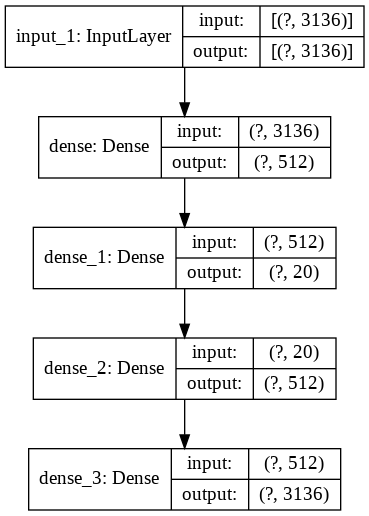

In [7]:
def autoencoder():
  input_img = tf.keras.layers.Input(shape=(image_size,))

  #인코더 정의
  encoded = tf.keras.layers.Dense(mid_dim,activation = 'relu')(input_img)
  encoded = tf.keras.layers.Dense(h_dim, activation='relu')(encoded)

  #디코더 정의
  decoded = tf.keras.layers.Dense(mid_dim,activation = 'relu')(encoded)
  decoded = tf.keras.layers.Dense(image_size, activation='sigmoid')(decoded)

  #AE 정의
  return Model(input_img,decoded)

#AE 모델 정의
model = autoencoder()

#모델 네트워크 확인
model.summary()
plot_model(model, to_file='ae.png', show_shapes=True)

## GradientTape로 모델학습 

In [0]:
#Hyperparameters
num_epochs = 100
learning_rate = 1e-3
batch_size = 20     # 배치 사이즈(나눴을때 이미지 갯수에 딱 떨어지게 설정해야 함)
BUFFER_SIZE = np.shape(x_train)[0]  # 총 이미지 갯수

# 데이터 배치를 만들고 섞어줌
train_ds = tf.data.Dataset.from_tensor_slices((x_train)).shuffle(BUFFER_SIZE).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test)).batch(batch_size)

# loss 함수와 optimizer 설정
loss_object = tf.keras.losses.MeanSquaredError() 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate))       


In [0]:
# `tf.function` 이 데코레이터는 함수를 "컴파일" 한다.
@tf.function
def train_step(x,model):
  with tf.GradientTape() as tape:
    recon_x = model(x) # AE 모델에 image 학습
    recon_loss = loss_object(x, recon_x) # 실제 이미지와 복원한 이미지의 차이를 계산해 loss값 구함

  # tape에 기록하며 미분이 실행됨
  gradients = tape.gradient(recon_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return recon_loss

# train 함수 정의
def train(train_ds,num_epochs):
  for epoch in range(num_epochs):
    for step, x in enumerate(train_ds):
        recon_loss = train_step(x,model)
        if step == 0:
            print("Epoch[{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, float(recon_loss)))
            model.save_weights('ae_bracket.h5')

In [17]:
train(train_ds,num_epochs)

Epoch[1/100], Loss: 0.0102
Epoch[2/100], Loss: 0.0114
Epoch[3/100], Loss: 0.0103
Epoch[4/100], Loss: 0.0092
Epoch[5/100], Loss: 0.0112
Epoch[6/100], Loss: 0.0091
Epoch[7/100], Loss: 0.0106
Epoch[8/100], Loss: 0.0110
Epoch[9/100], Loss: 0.0138
Epoch[10/100], Loss: 0.0096
Epoch[11/100], Loss: 0.0084
Epoch[12/100], Loss: 0.0109
Epoch[13/100], Loss: 0.0092
Epoch[14/100], Loss: 0.0080
Epoch[15/100], Loss: 0.0102
Epoch[16/100], Loss: 0.0090
Epoch[17/100], Loss: 0.0088
Epoch[18/100], Loss: 0.0090
Epoch[19/100], Loss: 0.0092
Epoch[20/100], Loss: 0.0108
Epoch[21/100], Loss: 0.0083
Epoch[22/100], Loss: 0.0114
Epoch[23/100], Loss: 0.0111
Epoch[24/100], Loss: 0.0098
Epoch[25/100], Loss: 0.0098
Epoch[26/100], Loss: 0.0090
Epoch[27/100], Loss: 0.0105
Epoch[28/100], Loss: 0.0103
Epoch[29/100], Loss: 0.0111
Epoch[30/100], Loss: 0.0092
Epoch[31/100], Loss: 0.0110
Epoch[32/100], Loss: 0.0091
Epoch[33/100], Loss: 0.0084
Epoch[34/100], Loss: 0.0117
Epoch[35/100], Loss: 0.0093
Epoch[36/100], Loss: 0.0093
E

## 원본이미지와 복원이미지 비교

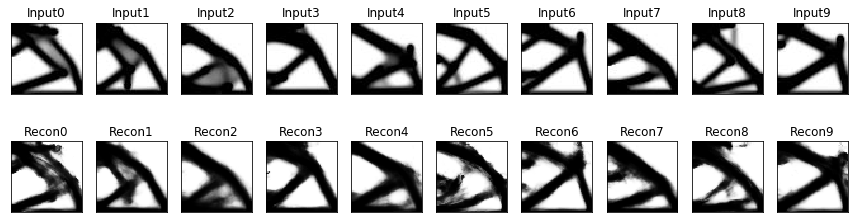

In [18]:
recon_x_test = model.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()